# Image Deterioration via DDCNN Data Augmentation Method

##### Alternative for this method: Utilize the Kaggle Dataset: [Art Images Clear and Distorted](https://www.kaggle.com/datasets/sankarmechengg/art-images-clear-and-distorted)

In [3]:
# !pip install opencv-python

In [21]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageEnhance, ImageDraw
import random
import os

In [5]:
def cv2_to_pil(cv_image):
    """Converts an OpenCV image (BGR or Grayscale) to a PIL image."""
    if len(cv_image.shape) == 2: # Grayscale
        return Image.fromarray(cv_image)
    elif len(cv_image.shape) == 3: # Color
        return Image.fromarray(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
    return None

In [6]:
def pil_to_cv2(pil_image):
    """Converts a PIL image to an OpenCV image (BGR)."""
    if pil_image.mode == 'RGB':
        return cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    elif pil_image.mode == 'L': # Grayscale
        return np.array(pil_image)
    elif pil_image.mode == 'RGBA': # Handle RGBA by converting to RGB first
        rgb_image = pil_image.convert('RGB')
        return cv2.cvtColor(np.array(rgb_image), cv2.COLOR_RGB2BGR)
    return np.array(pil_image)

### Damage Functions

In [7]:
def add_gaussian_noise(image_cv, mean=0, sigma_range=(10, 50)):
    """Adds additive Gaussian noise to an image."""
    sigma = random.uniform(sigma_range[0], sigma_range[1])
    row, col, ch = image_cv.shape if len(image_cv.shape) == 3 else (image_cv.shape[0], image_cv.shape[1], 1)
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy_image = image_cv + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)

In [8]:
def add_speckle_noise(image_cv, intensity_range=(0.05, 0.2)):
    """Adds speckle noise to an image."""
    intensity = random.uniform(intensity_range[0], intensity_range[1])
    row, col, ch = image_cv.shape if len(image_cv.shape) == 3 else (image_cv.shape[0], image_cv.shape[1], 1)
    gauss = np.random.randn(row, col, ch) * intensity
    gauss = gauss.reshape(row, col, ch)
    noisy_image = image_cv + image_cv * gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)

In [9]:
def apply_gaussian_blur(image_cv, kernel_size_range=(5, 15)):
    """Applies Gaussian blur."""
    # Kernel size must be odd
    k_size = random.randrange(kernel_size_range[0], kernel_size_range[1] + 1, 2)
    return cv2.GaussianBlur(image_cv, (k_size, k_size), 0)

In [10]:
def apply_motion_blur(image_cv, kernel_size_range=(10, 30)):
    """Applies motion blur."""
    kernel_size = random.randint(kernel_size_range[0], kernel_size_range[1])
    kernel = np.zeros((kernel_size, kernel_size))
    
    # Random angle for motion blur
    angle = random.uniform(0, 180) 
    if angle < 45 or angle > 135 : # Horizontal-ish
        kernel[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
    else: # Vertical-ish
        kernel[:, int((kernel_size-1)/2)] = np.ones(kernel_size)
        
    kernel = kernel / kernel_size
    return cv2.filter2D(image_cv, -1, kernel)

In [11]:
def apply_fade(image_pil, factor_range=(0.4, 0.8)):
    """Applies a fade effect (reduces contrast and brightness slightly)."""
    factor = random.uniform(factor_range[0], factor_range[1])
    enhancer = ImageEnhance.Contrast(image_pil)
    faded_image = enhancer.enhance(factor)
    # Optionally slightly reduce brightness too
    enhancer_brightness = ImageEnhance.Brightness(faded_image)
    faded_image = enhancer_brightness.enhance(random.uniform(0.8, 1.0))
    return faded_image

In [12]:
def apply_white_overlay(image_pil, alpha_range=(0.1, 0.4)):
    """Applies a semi-transparent white overlay."""
    alpha = random.uniform(alpha_range[0], alpha_range[1])
    white_layer = Image.new('RGBA', image_pil.size, (255, 255, 255, 0)) # Transparent white
    draw = ImageDraw.Draw(white_layer)
    draw.rectangle([(0,0), image_pil.size], fill=(255,255,255, int(alpha*255)))
    
    if image_pil.mode != 'RGBA':
        image_pil = image_pil.convert('RGBA')
        
    return Image.alpha_composite(image_pil, white_layer).convert('RGB')

In [13]:
def apply_swirl(image_cv, strength_range=(0.1, 0.5), radius_factor_range=(0.2, 0.8)):
    """Applies a swirl distortion."""
    rows, cols = image_cv.shape[:2]
    center_x, center_y = cols // 2, rows // 2
    
    strength = random.uniform(strength_range[0], strength_range[1]) * 100 # Scale strength
    radius = min(rows, cols) * random.uniform(radius_factor_range[0], radius_factor_range[1])

    map_x = np.zeros((rows, cols), dtype=np.float32)
    map_y = np.zeros((rows, cols), dtype=np.float32)

    for r in range(rows):
        for c in range(cols):
            dx = c - center_x
            dy = r - center_y
            distance = np.sqrt(dx*dx + dy*dy)
            if distance < radius:
                angle = strength * (radius - distance) / radius # Swirl angle decreases with distance
                angle_rad = np.deg2rad(angle)
                
                new_x = dx * np.cos(angle_rad) - dy * np.sin(angle_rad) + center_x
                new_y = dx * np.sin(angle_rad) + dy * np.cos(angle_rad) + center_y
                
                map_x[r, c] = new_x
                map_y[r, c] = new_y
            else:
                map_x[r, c] = float(c)
                map_y[r, c] = float(r)
                
    return cv2.remap(image_cv, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

In [14]:
def add_scratches(image_pil, num_scratches_range=(1, 10), max_length_factor=0.8, thickness_range=(1,3), color_range=((0,50),(200,255))):
    """Adds scratches to an image."""
    draw = ImageDraw.Draw(image_pil)
    width, height = image_pil.size
    num_scratches = random.randint(num_scratches_range[0], num_scratches_range[1])

    for _ in range(num_scratches):
        x1 = random.randint(0, width)
        y1 = random.randint(0, height)
        
        # Determine length and angle
        scratch_length = random.uniform(0.1, max_length_factor) * min(width, height)
        angle = random.uniform(0, 2 * np.pi)
        
        x2 = int(x1 + scratch_length * np.cos(angle))
        y2 = int(y1 + scratch_length * np.sin(angle))
        
        # Clip coordinates to be within image bounds
        x2 = max(0, min(width - 1, x2))
        y2 = max(0, min(height - 1, y2))

        thickness = random.randint(thickness_range[0], thickness_range[1])
        # Scratches can be dark or light
        if random.random() > 0.5: # Dark scratch
            color_val = random.randint(color_range[0][0], color_range[0][1])
        else: # Light scratch
            color_val = random.randint(color_range[1][0], color_range[1][1])
        color = (color_val, color_val, color_val)

        draw.line([(x1, y1), (x2, y2)], fill=color, width=thickness)
    return image_pil

In [15]:
def apply_water_discolouration(image_pil, num_stains_range=(1,5), stain_size_factor_range=(0.1, 0.4), alpha_range=(50,150), color_tint=(200,180,150)):
    """Simulates water discolouration stains. This is a simplified version."""
    # This is a very basic simulation. Real water stains are complex.
    # It creates semi-transparent, irregularly shaped blobs of a brownish tint.
    overlay = Image.new('RGBA', image_pil.size, (0,0,0,0)) # Transparent overlay
    draw = ImageDraw.Draw(overlay)
    width, height = image_pil.size
    num_stains = random.randint(num_stains_range[0], num_stains_range[1])

    for _ in range(num_stains):
        stain_radius_w = random.uniform(stain_size_factor_range[0], stain_size_factor_range[1]) * width / 2
        stain_radius_h = random.uniform(stain_size_factor_range[0], stain_size_factor_range[1]) * height / 2
        
        center_x = random.randint(0, width)
        center_y = random.randint(0, height)
        
        # Create an irregular ellipse
        # For simplicity, we'll use a regular ellipse here
        bbox = [center_x - stain_radius_w, center_y - stain_radius_h,
                center_x + stain_radius_w, center_y + stain_radius_h]
        
        alpha = random.randint(alpha_range[0], alpha_range[1])
        stain_color = (color_tint[0], color_tint[1], color_tint[2], alpha)
        draw.ellipse(bbox, fill=stain_color)
        
    # Blur the overlay to make stains smoother
    overlay = overlay.filter(ImageFilter.GaussianBlur(radius=random.uniform(5,15)))

    if image_pil.mode != 'RGBA':
        image_pil = image_pil.convert('RGBA')
        
    return Image.alpha_composite(image_pil, overlay).convert('RGB')

In [16]:
def apply_pixelation(image_cv, pixel_size_range=(8, 20)):
    """Applies pixelation effect."""
    height, width = image_cv.shape[:2]
    pixel_size = random.randint(pixel_size_range[0], pixel_size_range[1])

    # Resize down to pixelated size
    temp_img = cv2.resize(image_cv, (width // pixel_size, height // pixel_size), interpolation=cv2.INTER_NEAREST)
    # Resize back to original size
    pixelated_img = cv2.resize(temp_img, (width, height), interpolation=cv2.INTER_NEAREST)
    return pixelated_img

In [17]:
def apply_darkening(image_pil, factor_range=(0.3, 0.7)):
    """Applies a darkening effect."""
    factor = random.uniform(factor_range[0], factor_range[1])
    enhancer = ImageEnhance.Brightness(image_pil)
    return enhancer.enhance(factor)

In [18]:
def add_tears(image_pil, num_tears_range=(1,3), max_tear_length_factor=0.5, tear_width_range=(5,20), background_color=(200,200,200)):
    """Simulates tears by drawing irregular polygons filled with a background color."""
    # This is a simplified simulation. Real tears are complex.
    # We'll draw irregular "torn" areas and fill them.
    
    # Convert to RGBA to handle transparency if needed, then back to RGB
    original_mode = image_pil.mode
    if original_mode != 'RGBA':
        image_pil = image_pil.convert('RGBA')
    
    draw = ImageDraw.Draw(image_pil) # Draw on the RGBA version
    width, height = image_pil.size
    num_tears = random.randint(num_tears_range[0], num_tears_range[1])

    for _ in range(num_tears):
        # Start tear from an edge
        edge = random.choice(['top', 'bottom', 'left', 'right'])
        if edge == 'top':
            start_x, start_y = random.randint(0, width), 0
        elif edge == 'bottom':
            start_x, start_y = random.randint(0, width), height -1
        elif edge == 'left':
            start_x, start_y = 0, random.randint(0, height)
        else: # right
            start_x, start_y = width -1, random.randint(0, height)

        tear_points = [(start_x, start_y)]
        current_x, current_y = start_x, start_y
        tear_length = random.uniform(0.1, max_tear_length_factor) * min(width, height)
        num_segments = random.randint(3, 7) # Number of points in the tear path
        
        for i in range(num_segments):
            # Move inwards and randomly
            if edge in ['top', 'bottom']:
                current_y += (1 if edge == 'top' else -1) * (tear_length / num_segments)
                current_x += random.uniform(-tear_length/3, tear_length/3)
            else: # left, right
                current_x += (1 if edge == 'left' else -1) * (tear_length / num_segments)
                current_y += random.uniform(-tear_length/3, tear_length/3)

            # Add some jaggedness
            rand_offset_x = random.randint(-tear_width_range[1], tear_width_range[1])
            rand_offset_y = random.randint(-tear_width_range[1], tear_width_range[1])
            
            # Create two points for the "width" of the tear
            p1_x = max(0, min(width-1, int(current_x + rand_offset_x)))
            p1_y = max(0, min(height-1, int(current_y + rand_offset_y)))
            
            # Ensure the tear progresses generally
            tear_points.append((p1_x, p1_y))

        # Create a polygon from these points, ensuring some width
        # This is tricky to make look like a natural tear.
        # For simplicity, we'll draw a wide path and then fill.
        # A more advanced method would involve masking.
        if len(tear_points) > 2:
            # Create a "thick" line by drawing multiple parallel lines or a polygon
            # This simplified version just draws a polygon.
            # To make it look more like a tear, we need to create a "gap"
            # For this version, we'll fill a polygon.
            
            # Create a polygon that represents the torn area
            # This is highly simplified.
            poly_points = []
            for i in range(len(tear_points)):
                px, py = tear_points[i]
                angle = np.arctan2(py - start_y, px - start_x) + np.pi/2 # Perpendicular
                w = random.randint(tear_width_range[0], tear_width_range[1]) / 2
                poly_points.append( (int(px + w * np.cos(angle)), int(py + w * np.sin(angle))) )
            for i in range(len(tear_points) -1, -1, -1):
                px, py = tear_points[i]
                angle = np.arctan2(py - start_y, px - start_x) - np.pi/2 # Perpendicular other side
                w = random.randint(tear_width_range[0], tear_width_range[1]) / 2
                poly_points.append( (int(px + w * np.cos(angle)), int(py + w * np.sin(angle))) )

            if poly_points:
                 # Fill with a background color, simulating exposed canvas/backing
                 # Use RGBA for background_color to control transparency of the fill
                 draw.polygon(poly_points, fill=(background_color[0], background_color[1], background_color[2], 255))


    return image_pil.convert(original_mode) # Convert back to original mode

### Testing on the Painting Dataset

In [22]:
with open('data/canvas_metadata.json', 'r', encoding='utf-8') as f:
    metadata_list = json.load(f)
df = pd.DataFrame(metadata_list)
print(f'Metadata file shape:\n{df.shape}')
print(f'Columns:\n{list(df.columns)}')
df.head()

Metadata file shape:
(34658, 21)
Columns:
['Id', 'URL', 'Title', 'OriginalTitle', 'Author', 'AuthorLink', 'Date', 'Styles', 'Series', 'SeriesLink', 'Genre', 'GenreLink', 'Media', 'Location', 'Dimensions', 'Description', 'WikiDescription', 'WikiLink', 'Tags', 'image_urls', 'images']


Id                                                URL  \
0   2  https://www.wikiart.org/en/joe-machine/me-and-...   
1   1  https://www.wikiart.org/en/joe-machine/sex-cri...   
2   0  https://www.wikiart.org/en/joe-machine/two-gir...   
3   3  https://www.wikiart.org/en/joe-machine/my-moth...   
4   4  https://www.wikiart.org/en/joe-machine/until-t...   

                        Title OriginalTitle       Author  \
0       Me and My Grandfather          None  Joe Machine   
1       Sex Crime Variation 2          None  Joe Machine   
2                 Two Girlies          None  Joe Machine   
3  My Mother's Last Cigarette          None  Joe Machine   
4  Until the Last Dog is Hung          None  Joe Machine   

                               AuthorLink  Date  \
0  https://www.wikiart.org/en/joe-machine  None   
1  https://www.wikiart.org/en/joe-machine  None   
2  https://www.wikiart.org/en/joe-machine  None   
3  https://www.wikiart.org/en/joe-machine  None   
4  https://www.wikiart.org/en/joe-machine  None   

                                              Styles Series SeriesLink  ...  \
0  [[Stuckism, https://www.wikiart.org/en/paintin...   None       None  ...   
1  [[Stuckism, https://www.wikiart.org/en/paintin...   None       None  ...   
2  [[Stuckism, https://www.wikiart.org/en/paintin...   None       None  ...   
3  [[Stuckism, https://www.wikiart.org/en/paintin...   None       None  ...   
4  [[Stuckism, https://www.wikiart.org/en/paintin...   None       None  ...   

                                           GenreLink  \
0  https://www.wikiart.org/en/paintings-by-genre/...   
1  https://www.wikiart.org/en/paintings-by-genre/...   
2  https://www.wikiart.org/en/paintings-by-genre/...   
3  https://www.wikiart.org/en/paintings-by-genre/...   
4  https://www.wikiart.org/en/paintings-by-genre/...   

                                               Media Location   Dimensions  \
0  [[acrylic, https://www.wikiart.org/en/painting...     None  100 x 80 cm   
1  [[acrylic, https://www.wikiart.org/en/painting...     None   99 x 38 cm   
2  [[acrylic, https://www.wikiart.org/en/painting...     None  122 x 91 cm   
3  [[acrylic, https://www.wikiart.org/en/painting...     None  100 x 80 cm   
4  [[acrylic, https://www.wikiart.org/en/painting...     None  80 x 100 cm   

  Description WikiDescription WikiLink  \
0                                 None   
1                                 None   
2                                 None   
3                                 None   
4                                 None   

                                                Tags  \
0                                                 []   
1                                                 []   
2                               [female-nude, Human]   
3                                                 []   
4  [Mammal, Vertebrate, Dog, Canidae, American pi...   

                                          image_urls  \
0  [https://uploads1.wikiart.org/00226/images/joe...   
1  [https://uploads2.wikiart.org/00226/images/joe...   
2  [https://uploads2.wikiart.org/00226/images/joe...   
3  [https://uploads4.wikiart.org/00226/images/joe...   
4  [https://uploads4.wikiart.org/00226/images/joe...   

                                              images  
0  [{'url': 'https://uploads1.wikiart.org/00226/i...  
1  [{'url': 'https://uploads2.wikiart.org/00226/i...  
2  [{'url': 'https://uploads2.wikiart.org/00226/i...  
3  [{'url': 'https://uploads4.wikiart.org/00226/i...  
4  [{'url': 'https://uploads4.wikiart.org/00226/i...  

[5 rows x 21 columns]

data/img/full/b7b949e6e3d94c1310ce741c80c916c0e9a290ea.jpg


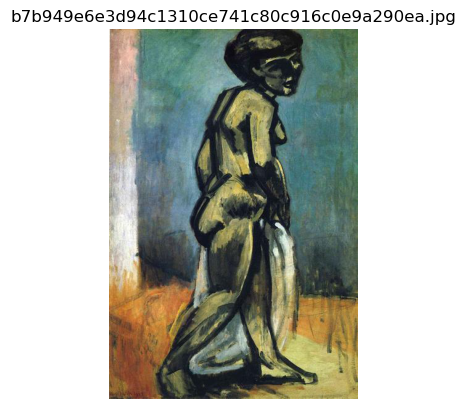

In [23]:
IMAGE_DIR = 'data/img/full'

image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')]

random_file = random.choice(image_files)
random_path = os.path.join(IMAGE_DIR, random_file)

# Display sample image
print(random_path)
img = Image.open(random_path)
plt.imshow(img)
plt.axis('off')
plt.title(random_file)
plt.show()

In [24]:
# --- Main Application Example ---
if __name__ == "__main__":
    # Load a sample image (replace with your image loading logic)
    # Create a dummy image for testing if no image is available
    sample_image_path = random_path # Provide a path to a test image
    output_dir = "DDCNN_Outputs/damaged_images_output"
    os.makedirs(output_dir, exist_ok=True)

    try:
        img_pil = Image.open(sample_image_path)
        print(f"Successfully loaded image: {sample_image_path}")
    except FileNotFoundError:
        print(f"Sample image '{sample_image_path}' not found. Creating a dummy image for testing.")
        img_pil = Image.new('RGB', (512, 512), color = (150, 120, 100))
        draw = ImageDraw.Draw(img_pil)
        draw.text((10,10), "Sample Painting", fill=(255,255,0))
        img_pil.save(sample_image_path) # Save the dummy for next time
        print(f"Dummy image saved as {sample_image_path}")

    img_cv = pil_to_cv2(img_pil.copy()) # Work with copies

    # List of damage functions to apply (function, type: 'pil' or 'cv')
    damage_functions = [
        (add_gaussian_noise, 'cv'),
        (add_speckle_noise, 'cv'),
        (apply_gaussian_blur, 'cv'),
        (apply_motion_blur, 'cv'),
        (apply_fade, 'pil'),
        (apply_white_overlay, 'pil'),
        (apply_swirl, 'cv'),
        (add_scratches, 'pil'),
        # (apply_water_discolouration, 'pil'), # Water discolouration needs PIL ImageFilter
        (apply_pixelation, 'cv'),
        (apply_darkening, 'pil'),
        (add_tears, 'pil')
    ]
    
    # For apply_water_discolouration, PIL ImageFilter is needed.
    # Make sure Pillow is updated: pip install --upgrade Pillow
    # Then uncomment the line above and the import below if you want to test it.
    try:
        from PIL import ImageFilter
        damage_functions.insert(8, (apply_water_discolouration, 'pil'))
        print("ImageFilter available, water discolouration enabled.")
    except ImportError:
        print("ImageFilter not found (Pillow might be old). Skipping water discolouration.")


    # Apply and save each damage type individually
    for func, img_type in damage_functions:
        print(f"Applying: {func.__name__}")
        if img_type == 'pil':
            current_img_pil = img_pil.copy()
            damaged_img_pil = func(current_img_pil)
            if damaged_img_pil:
                damaged_img_pil.save(os.path.join(output_dir, f"damaged_{func.__name__}.png"))
        elif img_type == 'cv':
            current_img_cv = img_cv.copy()
            damaged_img_cv = func(current_img_cv)
            if damaged_img_cv is not None:
                cv2.imwrite(os.path.join(output_dir, f"damaged_{func.__name__}.png"), damaged_img_cv)
        print(f"Saved: damaged_{func.__name__}.png")

    # Example of applying multiple damages sequentially
    print("\nApplying multiple damages sequentially...")
    multi_damaged_pil = img_pil.copy()
    multi_damaged_cv = pil_to_cv2(multi_damaged_pil)

    # 1. Add noise
    multi_damaged_cv = add_gaussian_noise(multi_damaged_cv, sigma_range=(5,15))
    # 2. Apply blur
    multi_damaged_cv = apply_gaussian_blur(multi_damaged_cv, kernel_size_range=(3,7))
    # Convert to PIL for PIL-based functions
    multi_damaged_pil = cv2_to_pil(multi_damaged_cv)
    # 3. Add scratches
    multi_damaged_pil = add_scratches(multi_damaged_pil, num_scratches_range=(2,5), thickness_range=(1,2))
    # 4. Apply fade
    multi_damaged_pil = apply_fade(multi_damaged_pil, factor_range=(0.6, 0.8))

    multi_damaged_pil.save(os.path.join(output_dir, "damaged_multiple_effects.png"))
    print("Saved: damaged_multiple_effects.png")

    print(f"\nAll damaged images saved in '{output_dir}' directory.")
    print("Review the generated images. You can combine these functions and vary their parameters to create 50 distinct variations per original image as mentioned in the paper.")

Successfully loaded image: data/img/full/b7b949e6e3d94c1310ce741c80c916c0e9a290ea.jpg
ImageFilter available, water discolouration enabled.
Applying: add_gaussian_noise
Saved: damaged_add_gaussian_noise.png
Applying: add_speckle_noise
Saved: damaged_add_speckle_noise.png
Applying: apply_gaussian_blur
Saved: damaged_apply_gaussian_blur.png
Applying: apply_motion_blur
Saved: damaged_apply_motion_blur.png
Applying: apply_fade
Saved: damaged_apply_fade.png
Applying: apply_white_overlay
Saved: damaged_apply_white_overlay.png
Applying: apply_swirl
Saved: damaged_apply_swirl.png
Applying: add_scratches
Saved: damaged_add_scratches.png
Applying: apply_water_discolouration
Saved: damaged_apply_water_discolouration.png
Applying: apply_pixelation
Saved: damaged_apply_pixelation.png
Applying: apply_darkening
Saved: damaged_apply_darkening.png
Applying: add_tears
Saved: damaged_add_tears.png

Applying multiple damages sequentially...
Saved: damaged_multiple_effects.png

All damaged images saved in '

In [ ]:
IMAGE_DIR = 'DDCNN_Outputs'

damaged_files = [f for f in os.listdir(IMAGE_DIR) if f == random_file]

for damaged_img in damaged_files:
    random_path = os.path.join(IMAGE_DIR, damaged_file)
    
    img = Image.open(random_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(random_file)
    plt.show()

In [25]:
random_path

'data/img/full/b7b949e6e3d94c1310ce741c80c916c0e9a290ea.jpg'

In [26]:
random_file

'b7b949e6e3d94c1310ce741c80c916c0e9a290ea.jpg'

In [31]:
import math

# --- Configuration ---
# Path to the original image that was used as the base for generating damages
# This should match the 'sample_image_path' from the 'synthetic_damage_generation_v1' script
ORIGINAL_IMAGE_PATH = random_path

# Directory where the synthetically damaged images were saved
# This should match the 'output_dir' from the 'synthetic_damage_generation_v1' script
DAMAGED_IMAGES_DIR = "DDCNN_Outputs/damaged_images_output"

In [32]:
# --- Function to display images in a grid ---
def display_image_grid(image_paths, titles, main_title="Image Grid", cols=3):
    """
    Displays a list of images in a grid.

    Args:
        image_paths (list): List of paths to the image files.
        titles (list): List of titles corresponding to each image.
        main_title (str): Overall title for the plot.
        cols (int): Number of columns in the grid.
    """
    if not image_paths:
        print("No image paths provided to display.")
        return

    num_images = len(image_paths)
    rows = math.ceil(num_images / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    fig.suptitle(main_title, fontsize=16, y=1.02 if rows > 1 else 1.05) # Adjust y for suptitle based on rows
    
    # Flatten axes array for easy iteration, handle single row/col case
    if rows == 1 and cols == 1:
        axes = [[axes]] # Make it a 2D array-like structure
    elif rows == 1:
        axes = [axes]
    elif cols == 1:
        axes = [[ax] for ax in axes]
        
    axes_flat = [ax for sublist in axes for ax in sublist]

    for i, img_path in enumerate(image_paths):
        ax = axes_flat[i]
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(titles[i], fontsize=10)
            ax.axis('off')
        except FileNotFoundError:
            print(f"Error: Image not found at {img_path}")
            ax.text(0.5, 0.5, f"Image not found:\n{os.path.basename(img_path)}", 
                    ha='center', va='center', fontsize=8, color='red')
            ax.axis('off')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            ax.text(0.5, 0.5, f"Error loading:\n{os.path.basename(img_path)}", 
                    ha='center', va='center', fontsize=8, color='red')
            ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.98 if rows > 1 and main_title else 1]) # Adjust layout to make space for suptitle
    plt.show()

Loading damaged images from: DDCNN_Outputs/damaged_images_output
Found 13 damaged images.


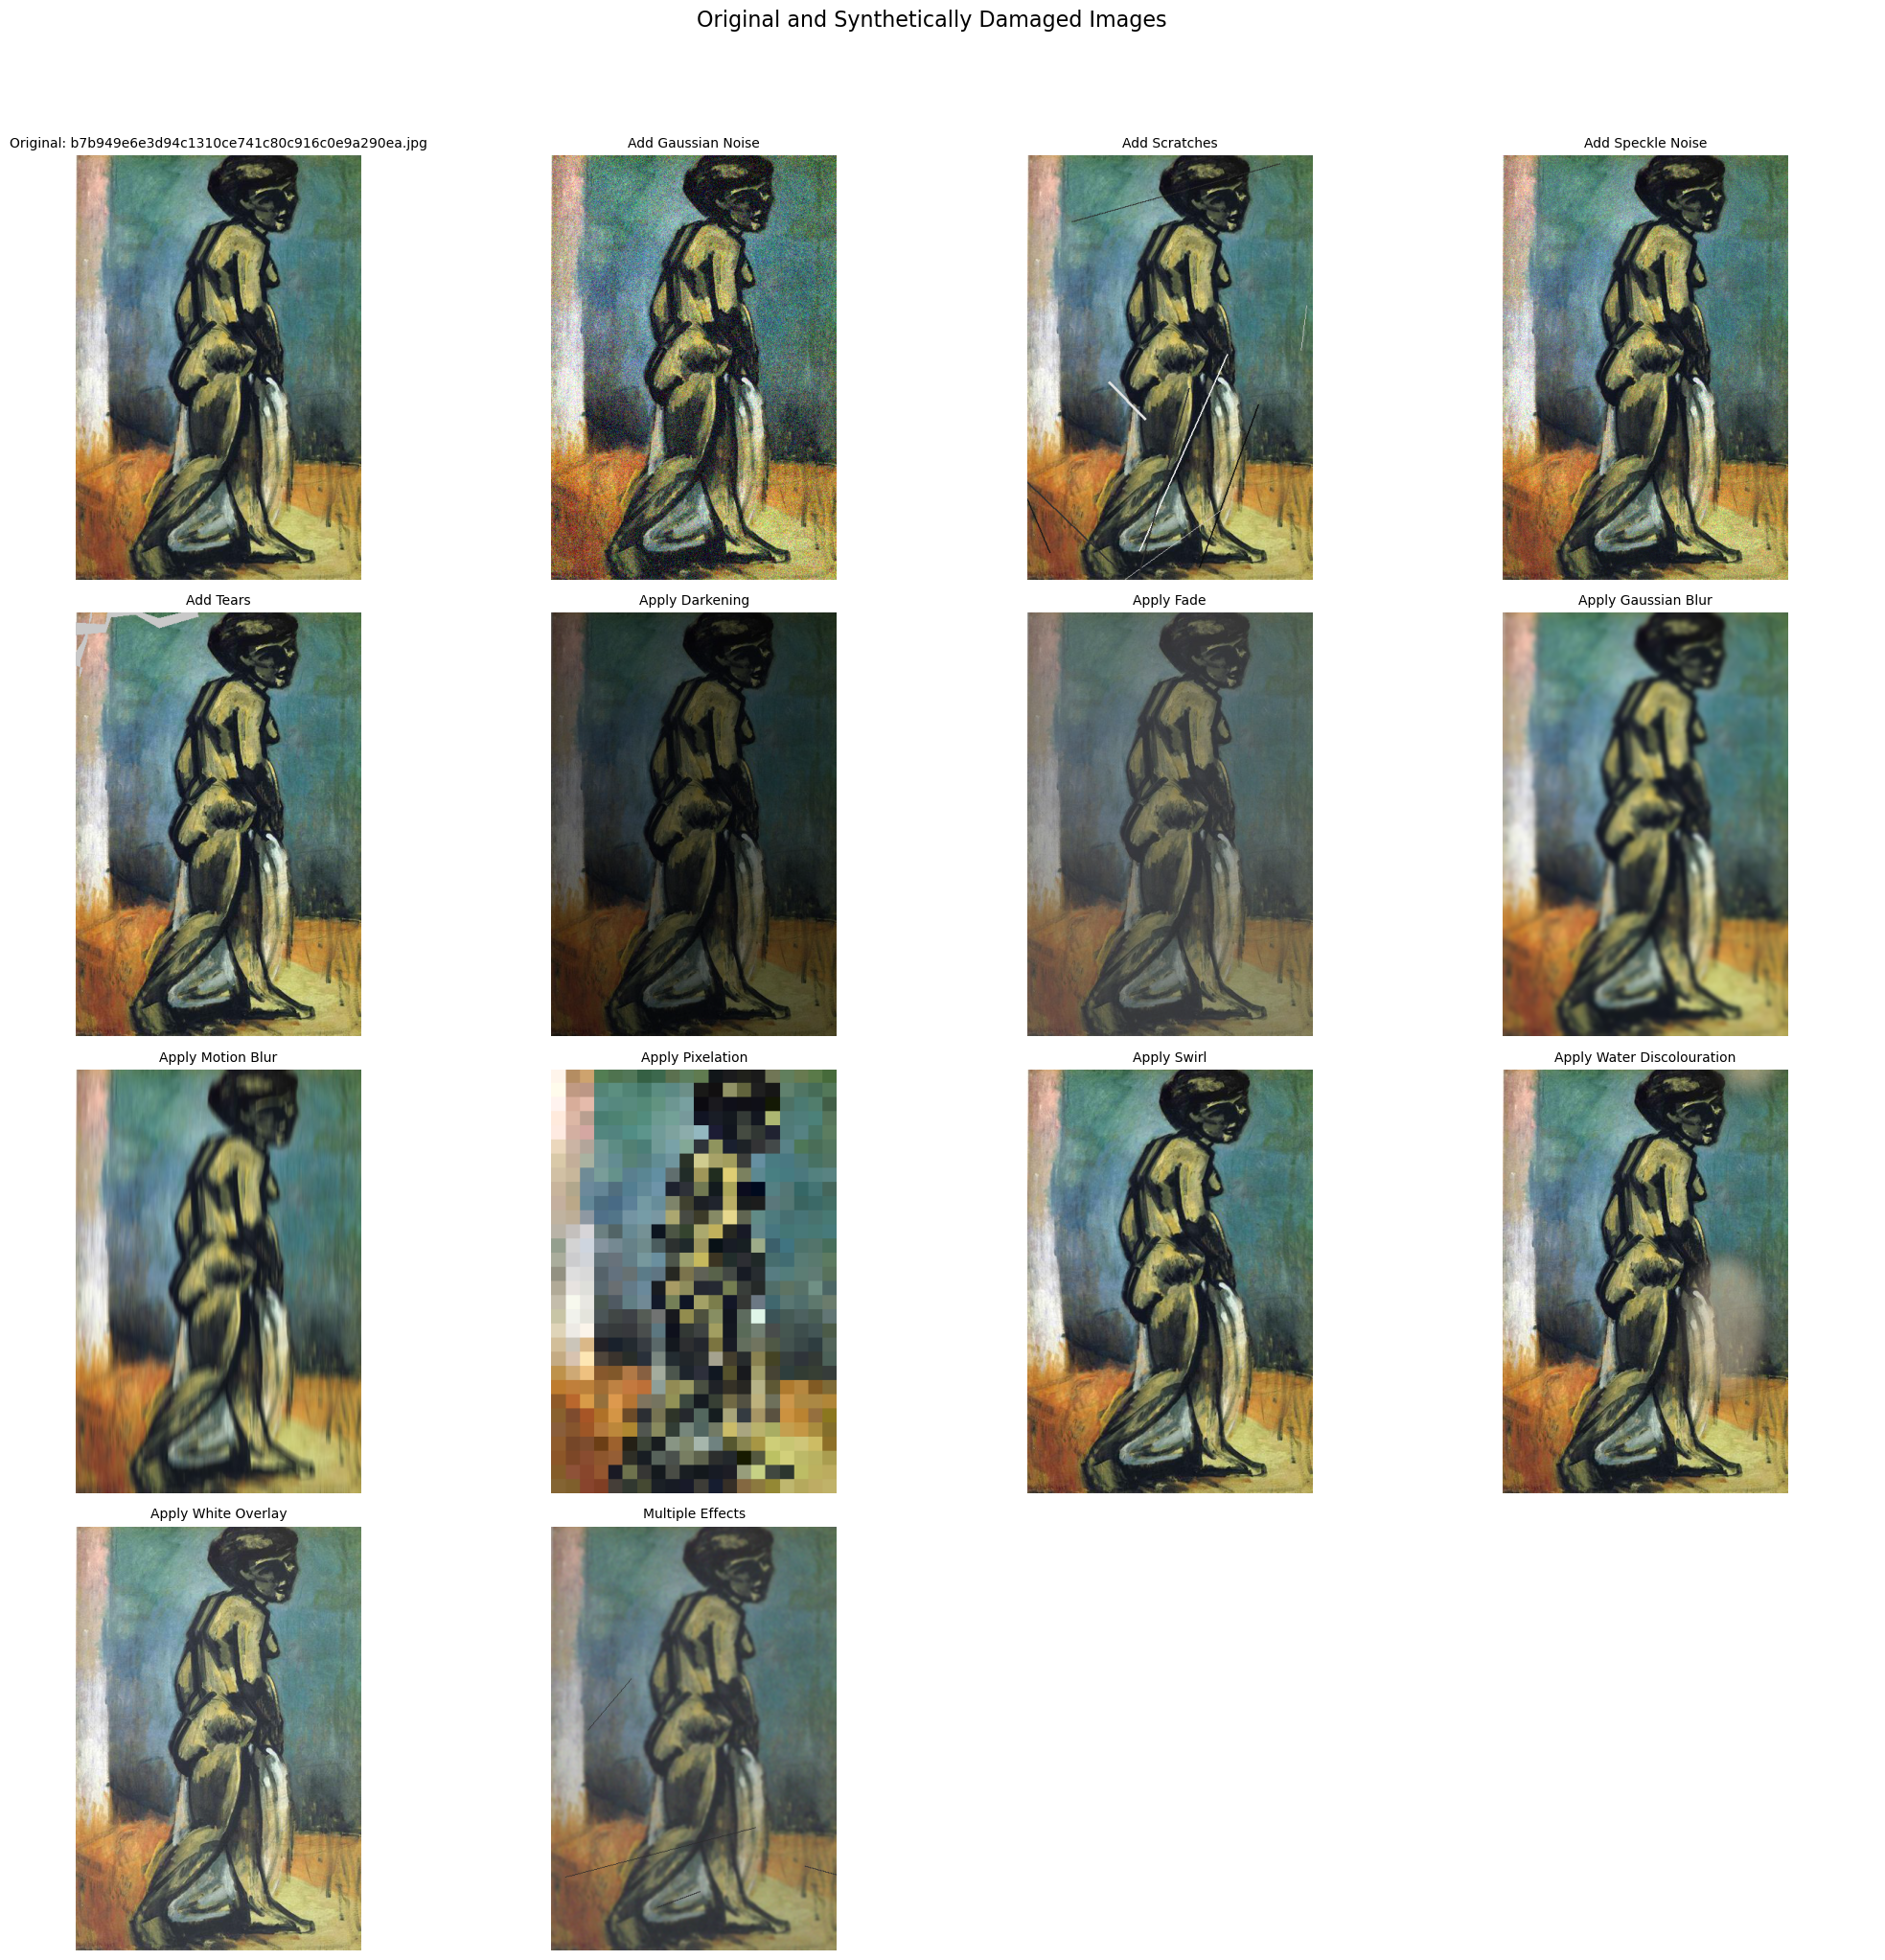

In [33]:
if __name__ == "__main__":
    all_image_paths_to_display = []
    all_titles = []

    # 1. Add the original image
    if os.path.exists(ORIGINAL_IMAGE_PATH):
        all_image_paths_to_display.append(ORIGINAL_IMAGE_PATH)
        all_titles.append(f"Original: {os.path.basename(ORIGINAL_IMAGE_PATH)}")
    else:
        print(f"Warning: Original image not found at '{ORIGINAL_IMAGE_PATH}'")

    # 2. List and add damaged images
    if os.path.isdir(DAMAGED_IMAGES_DIR):
        print(f"Loading damaged images from: {DAMAGED_IMAGES_DIR}")
        damaged_image_files = sorted([
            f for f in os.listdir(DAMAGED_IMAGES_DIR) 
            if os.path.isfile(os.path.join(DAMAGED_IMAGES_DIR, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])

        if damaged_image_files:
            for filename in damaged_image_files:
                full_path = os.path.join(DAMAGED_IMAGES_DIR, filename)
                all_image_paths_to_display.append(full_path)
                # Clean up title a bit (remove 'damaged_' prefix and extension)
                title = filename.replace("damaged_", "").rsplit('.', 1)[0].replace("_", " ").title()
                all_titles.append(title)
            print(f"Found {len(damaged_image_files)} damaged images.")
        else:
            print(f"No image files found in '{DAMAGED_IMAGES_DIR}'.")
    else:
        print(f"Error: Damaged images directory not found at '{DAMAGED_IMAGES_DIR}'")

    # 3. Display the images
    if all_image_paths_to_display:
        display_image_grid(all_image_paths_to_display, all_titles, 
                           main_title="Original and Synthetically Damaged Images", cols=4)
    else:
        print("No images to display. Please check paths and ensure synthetic damages were generated.")